# Influenza model - Intervention

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import model
import pickle
import itertools
import networkx as nx
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

### Prepare data

In [2]:
prep_data = model.data_and_network_prep()

### Data for fit

In [3]:
# Create data for the fit
data_for_fit = model.create_data_for_fit_influenza()

### Load Grid Seasrch Results

In [4]:
# 2017
with open('L:/Dor/Data/influenza_model/results/grid_search_2017_1_res.pickle', 'rb') as pickle_in:
    grid_search_res1 = pickle.load(pickle_in)
    
with open('L:/Dor/Data/influenza_model/results/grid_search_2017_2_res.pickle', 'rb') as pickle_in:
    grid_search_res2 = pickle.load(pickle_in)
    
with open('L:/Dor/Data/influenza_model/results/grid_search_2017_3_res.pickle', 'rb') as pickle_in:
    grid_search_res3 = pickle.load(pickle_in)
    
grid_search_res = grid_search_res1 + grid_search_res2 + grid_search_res3

In [5]:
# # 2016
# with open('L:/Dor/Data/influenza_model/results/grid_search_2016_1_res.pickle', 'rb') as pickle_in:
#     grid_search_res1 = pickle.load(pickle_in)
    
# with open('L:/Dor/Data/influenza_model/results/grid_search_2016_2_res.pickle', 'rb') as pickle_in:
#     grid_search_res2 = pickle.load(pickle_in)

# grid_search_res = grid_search_res1 #+ grid_search_res2

In [6]:
# 2016
with open('L:/Dor/Data/influenza_model/results/grid_search_2016_1_new_res.pickle', 'rb') as pickle_in:
    grid_search_res = pickle.load(pickle_in)

#### Get best parametrs according to each likelihood function

In [7]:
# Max likelihood 
liklihood = max(grid_search_res, key=lambda x: x['log_likelihood'])

# Max likelihood age
liklihood_age = max(grid_search_res, key=lambda x: x['log_likelihood_age'])

# Max likelihood subdist
liklihood_subdist = max(grid_search_res, key=lambda x: x['log_likelihood_subdist'])


print(f"Max likelihood: {int(liklihood_age['log_likelihood']):,d}")
print(liklihood)
print('\n')

print(f"Max likelihood by age: {int(liklihood_age['log_likelihood_age']):,d}")
print(liklihood_age)
print('\n')

print(f"Max likelihood by subdist: {int(liklihood_subdist['log_likelihood_subdist']):,d}")
print(liklihood_subdist)
print('\n')

Max likelihood: -6,139
{'parameters': {2016: {'beta': 0.0015172649054787906, 'delta': 1, 'phi': -3.7226934580923317, 'epsilon': 1}}, 'log_likelihood': -5861.419218446221, 'log_likelihood_age': 28211.623864536934, 'log_likelihood_subdist': 14254.221664309898}


Max likelihood by age: 28,281
{'parameters': {2016: {'beta': 0.0015448276398101898, 'delta': 1, 'phi': -3.724241584382226, 'epsilon': 1}}, 'log_likelihood': -6139.711575619711, 'log_likelihood_age': 28281.29512928202, 'log_likelihood_subdist': 14697.936607799087}


Max likelihood by subdist: 14,697
{'parameters': {2016: {'beta': 0.0015448276398101898, 'delta': 1, 'phi': -3.724241584382226, 'epsilon': 1}}, 'log_likelihood': -6139.711575619711, 'log_likelihood_age': 28281.29512928202, 'log_likelihood_subdist': 14697.936607799087}




# Intervention

In [8]:
run_influenza_model = model.run_influenza_model

# def infection_rate_intervention_influenza(intervention_nodes, parameters, prep_data, season, num_of_simulations):
#     # Run the model num_of_simulations times
#     model_results_list = [run_influenza_model(parameters, prep_data, season, intervention_nodes=intervention_nodes)
#                           for i in range(num_of_simulations)]

#     # Calculate infection rate
#     model_res_infection_rate_list = [len(res['Rs'][-1]) / res['N'] for res in model_results_list]

#     # Get median realization
#     med = np.argsort(np.array(model_res_infection_rate_list))[len(model_res_infection_rate_list) // 2]

#     return model_results_list[med], model_res_infection_rate_list[med]

def infection_rate_intervention_influenza(intervention_nodes, parameters, prep_data, data_for_fit, season, num_of_simulations):
    # Initialize lists fo infection rate and effoective vaccination coverage
    model_res_infection_rate_list = []
    effective_vacc_coverage_list = []
    
    for i in range(num_of_simulations):
        # Run the model
        model_res = run_influenza_model(parameters, prep_data, season, intervention_nodes=intervention_nodes)

        # Calculate infection rate and add to the list
        model_res_infection_rate = model.get_infection_rate_by_age(model_res, data_for_fit, prep_data, season).model
        model_res_infection_rate_list.append(model_res_infection_rate)
        
        # Calculate effective vaccination coverage and add to the list
        effective_vacc_coverage = len(model_res['V_0'] - model_res['R'][0])/model_res['N']
        effective_vacc_coverage_list.append(effective_vacc_coverage)

    # Get median realization (by total infection rate)
    total_infection_rates = list(map(lambda x: x['total'], model_res_infection_rate_list))
    med = np.argsort(np.array(total_infection_rates))[len(total_infection_rates) // 2]

    # Return median realization's infection rate and effctive vaccination coverage
    return model_res_infection_rate_list[med], effective_vacc_coverage_list[med]

In [9]:
# Number of simulations
m = 10

season = 2016
intervention_percent = 0.15
intervention_size = int(round(prep_data['network'].number_of_nodes()*intervention_percent))

# parametes = liklihood['parameters']
# parameters = liklihood_age['parameters']
parameters = liklihood_subdist['parameters']

### No intervention

In [10]:
infect_rate_no_inter, base_vacc_cover = infection_rate_intervention_influenza(set(), parameters, prep_data, data_for_fit,
                                                                               season=season, num_of_simulations=m)

In [11]:
print(f'Effective vaccination coverage: {base_vacc_cover*100:.2f}%')
print(f'Total infection rate: {infect_rate_no_inter["total"]*100:.3f}%')

Effective vaccination coverage: 5.44%
Total infection rate: 8.194%


In [12]:
# model.plot_aggregated_fit_influenza(results_no_inter, data_for_fit, season=season)

### Random intervention

In [13]:
random_nodes = set(np.random.choice(list(prep_data['network'].nodes), replace=False, size=intervention_size))
infect_rate_random, effective_vacc_cover_random = infection_rate_intervention_influenza(random_nodes, parameters, prep_data, data_for_fit,
                                                                                        season=season, num_of_simulations=m)

In [14]:
print('Random intervention:')
print(f'Effective vaccination coverage: {effective_vacc_cover_random*100:.2f}%')
print(f'Effective vaccination coverage increase due to intervention: {(effective_vacc_cover_random-base_vacc_cover)*100:.2f}%')
print(f'Total infection rate: {infect_rate_random["total"]*100:.3f}%')
print(f'Total infection rate decrease: {(infect_rate_no_inter["total"]-infect_rate_random["total"])*100:.3f}%')

Random intervention:
Effective vaccination coverage: 9.08%
Effective vaccination coverage increase due to intervention: 3.63%
Total infection rate: 5.699%
Total infection rate decrease: 2.495%


In [15]:
# model.plot_aggregated_fit_influenza(results_random, data_for_fit, season=season)

### Centrality-based intervention

### Area-based centrality

#### Areas PageRank

In [16]:
# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)

In [17]:
# Load page ranks
with open(model.pagerank_by_area_age_path, 'rb') as pickle_in:
# with open('../../Data/vaccination_data/pagerank_by_area_age_thresh.pickle', 'rb') as pickle_in:
# with open('../../Data/vaccination_data/pagerank_by_area_age_net.pickle', 'rb') as pickle_in:
    pageranks = pickle.load(pickle_in)
    
# Sort areas and age groups by page rank (descending)
areas_age_by_rank_with_rank = sorted(list(pageranks.items()), key=lambda x: x[1], reverse=True)
areas_age_by_rank = list(map(lambda x: x[0], areas_age_by_rank_with_rank))

# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)
    
# Fliter irrelevant areas
areas_age_by_rank = list(filter(lambda x: x in nodes_by_area_age, areas_age_by_rank))
areas_age_by_rank_with_rank = list(filter(lambda x: x[0] in nodes_by_area_age, areas_age_by_rank_with_rank))

    
# Create a list of nodes by PageRank
nodes_by_rank = []
for (area, age) in areas_age_by_rank:
    nodes_by_rank += list(nodes_by_area_age[(area, age)])
    
# Get nodes to vaccinate
areas_PR_nodes = set(nodes_by_rank[:intervention_size])

# Run simulations
infect_rate_areas_PR, effective_vacc_cover_areas_PR = infection_rate_intervention_influenza(areas_PR_nodes,
                                                                                            parameters, prep_data, data_for_fit,
                                                                                            season=season, num_of_simulations=m)

In [18]:
print('By areas PageRank:')
print(f'Effective vaccination coverage: {effective_vacc_cover_areas_PR*100:.2f}%')
print(f'Effective vaccination coverage increase due to intervention: {(effective_vacc_cover_areas_PR-base_vacc_cover)*100:.2f}%')
print(f'Total infection rate: {infect_rate_areas_PR["total"]*100:.3f}%')
print(f'Total infection rate decrease: {(infect_rate_no_inter["total"]-infect_rate_areas_PR["total"])*100:.3f}%')

By areas PageRank:
Effective vaccination coverage: 9.14%
Effective vaccination coverage increase due to intervention: 3.69%
Total infection rate: 6.630%
Total infection rate decrease: 1.564%


In [19]:
# model.plot_aggregated_fit_influenza(results_areas_PR, data_for_fit, season=season)

#### Subgraphs areas PageRank (by subdist and age)

In [20]:
# Load page ranks - for each subdist separately
with open('../../Data/vaccination_data/sub_graphs_areas_pageranks.pickle', 'rb') as pickle_in:
    sub_graphs_areas_pageranks = pickle.load(pickle_in)

    # Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)
    
# Caculate population proportion by subdist and age
population_by_subdist = prep_data['population_by_clinic_age'].reset_index().groupby(['subdist', 'age']).sum()[['network_population']]
population_by_subdist['pop_prop'] = population_by_subdist.network_population / population_by_subdist.network_population.sum()

# Initialize a set for the nodes to vaccinate
subgraph_area_PR_nodes = set()

# Go over subdist and age and choose top nodes by subgraph PageRank
for subdist, age in prep_data['relevant_subdists_age']:
    # Sort nodes groups by page rank (descending)
    areas_by_subgraph_area_PR_with_rank = sorted(list(sub_graphs_areas_pageranks[(subdist, age)].items()), key=lambda x: x[1], reverse=True)
    areas_by_areas_subgraph_PR = list(map(lambda x: x[0], areas_by_subgraph_area_PR_with_rank))
    # Create a list of nodes by PageRank for current subdist and age
    nodes_by_rank = []
    for (area, age) in areas_by_areas_subgraph_PR:
        nodes_by_rank += list(nodes_by_area_age[(area, age)])
    # The number of nodes to vaccionate is according to the population proportion
    num_of_nodes = int(population_by_subdist.loc[(subdist, age)].pop_prop * intervention_size)
    # Get nodes to vaccinate in current subdist and age
    nodes_to_vacc_subdist = set(nodes_by_rank[:num_of_nodes])
    # Add to the set of nodes to vaccinate
    subgraph_area_PR_nodes = subgraph_area_PR_nodes.union(nodes_to_vacc_subdist)
    
# Run simulations
infect_rate_subgraph_area_PR, effective_vacc_cover_subgraph_area_PR = infection_rate_intervention_influenza(subgraph_area_PR_nodes,
                                                                                                            parameters, prep_data,
                                                                                                            data_for_fit, season=season,
                                                                                                            num_of_simulations=m)

In [21]:
print('By nodes subgraph area PageRank:')
print(f'Effective vaccination coverage: {effective_vacc_cover_subgraph_area_PR*100:.2f}%')
print(f'Effective vaccination coverage increase due to intervention: {(effective_vacc_cover_subgraph_area_PR-base_vacc_cover)*100:.2f}%')
print(f'Total infection rate: {infect_rate_subgraph_area_PR["total"]*100:.3f}%')
print(f'Total infection rate decrease: {(infect_rate_no_inter["total"]-infect_rate_subgraph_area_PR["total"])*100:.3f}%')

By nodes subgraph area PageRank:
Effective vaccination coverage: 9.16%
Effective vaccination coverage increase due to intervention: 3.72%
Total infection rate: 7.025%
Total infection rate decrease: 1.169%


In [22]:
# model.plot_aggregated_fit_influenza(results_subgraph_area_PR, data_for_fit, season=season)

### Node-based centrality

#### Nodes PageRank

In [23]:
# Load page ranks
with open('../../Data/vaccination_data/pagerank_by_node.pickle', 'rb') as pickle_in:
    pageranks_by_node = pickle.load(pickle_in)
    
# Sortnodes by page rank (descending)
nodes_by_rank_with_rank = sorted(list(pageranks_by_node.items()), key=lambda x: x[1], reverse=True)
nodes_by_nodes_pagerank = list(map(lambda x: x[0], nodes_by_rank_with_rank))

# Get nodes to vaccinate
nodes_PR_nodes = set(nodes_by_nodes_pagerank[:intervention_size])

# Run simulations
infect_rate_nodes_PR, effective_vacc_cover_nodes_PR = infection_rate_intervention_influenza(nodes_PR_nodes, parameters, prep_data,
                                                                           data_for_fit, season=season, num_of_simulations=m)

In [24]:
print('By nodes PageRank:')
print(f'Effective vaccination coverage: {effective_vacc_cover_nodes_PR*100:.2f}%')
print(f'Effective vaccination coverage increase due to intervention: {(effective_vacc_cover_nodes_PR-base_vacc_cover)*100:.2f}%')
print(f'Total infection rate: {infect_rate_nodes_PR["total"]*100:.3f}%')
print(f'Total infection rate decrease: {(infect_rate_no_inter["total"]-infect_rate_nodes_PR["total"])*100:.3f}%')

By nodes PageRank:
Effective vaccination coverage: 9.14%
Effective vaccination coverage increase due to intervention: 3.70%
Total infection rate: 1.153%
Total infection rate decrease: 7.042%


In [25]:
# model.plot_aggregated_fit_influenza(results_nodes_PR, data_for_fit, season=season)

#### Nodes degree

In [26]:
# Sort nodes by degree (descending)
nodes_by_dgree_with_dgree = sorted(list(dict(prep_data['network'].degree).items()), key=lambda x: x[1], reverse=True)
nodes_by_dgree = list(map(lambda x: x[0], nodes_by_dgree_with_dgree))

# Get nodes to vaccinate
nodes_degree = set(nodes_by_dgree[:intervention_size])

# Run simulations
infect_rate_nodes_degree, effective_vacc_cover_nodes_degree = infection_rate_intervention_influenza(nodes_degree, parameters, prep_data,
                                                                           data_for_fit, season=season, num_of_simulations=m)

In [27]:
print('By nodes degree:')
print(f'Effective vaccination coverage: {effective_vacc_cover_nodes_degree*100:.2f}%')
print(f'Effective vaccination coverage increase due to intervention: {(effective_vacc_cover_nodes_degree-base_vacc_cover)*100:.2f}%')
print(f'Total infection rate: {infect_rate_nodes_degree["total"]*100:.3f}%')
print(f'Total infection rate decrease: {(infect_rate_no_inter["total"]-infect_rate_nodes_degree["total"])*100:.3f}%')

By nodes degree:
Effective vaccination coverage: 9.30%
Effective vaccination coverage increase due to intervention: 3.85%
Total infection rate: 0.997%
Total infection rate decrease: 7.198%


In [28]:
# model.plot_aggregated_fit_influenza(results_nodes_degree, data_for_fit, season=season)

#### Subgraphs nodes PageRank (by subdist and age)

In [29]:
# Load page ranks - for each subdist separately
with open('../../Data/vaccination_data/sub_graphs_pageranks.pickle', 'rb') as pickle_in:
    sub_graphs_pageranks = pickle.load(pickle_in)

# Caculate population proportion by subdist and age
population_by_subdist = prep_data['population_by_clinic_age'].reset_index().groupby(['subdist', 'age']).sum()[['network_population']]
population_by_subdist['pop_prop'] = population_by_subdist.network_population / population_by_subdist.network_population.sum()

# Initialize a set for the nodes to vaccinate
subgraph_PR_nodes = set()

# Go over subdist and age and choose top nodes by subgraph PageRank
for subdist, age in prep_data['relevant_subdists_age']:
    # Sort nodes groups by page rank (descending)
    nodes_by_subgraph_PR_with_rank = sorted(list(sub_graphs_pageranks[(subdist, age)].items()), key=lambda x: x[1], reverse=True)
    nodes_by_nodes_subgraph_PR = list(map(lambda x: x[0], nodes_by_subgraph_PR_with_rank))
    # The number of nodes to vaccionate is according to the population proportion
    num_of_nodes = int(population_by_subdist.loc[(subdist, age)].pop_prop * intervention_size)
    # Get nodes to vaccinate in current subdist and age
    nodes_to_vacc_subdist = set(nodes_by_nodes_subgraph_PR[:num_of_nodes])
    # Add to the set of nodes to vaccinate
    subgraph_PR_nodes = subgraph_PR_nodes.union(nodes_to_vacc_subdist)
    
# Run simulations
infect_rate_subgraph_PR_nodes, effective_vacc_cover_subgraph_PR_nodes = infection_rate_intervention_influenza(subgraph_PR_nodes, parameters, prep_data,
                                                                           data_for_fit, season=season, num_of_simulations=m)

In [30]:
print('By nodes subgraph PageRank:')
print(f'Effective vaccination coverage: {effective_vacc_cover_subgraph_PR_nodes*100:.2f}%')
print(f'Effective vaccination coverage increase due to intervention: {(effective_vacc_cover_subgraph_PR_nodes-base_vacc_cover)*100:.2f}%')
print(f'Total infection rate: {infect_rate_subgraph_PR_nodes["total"]*100:.3f}%')
print(f'Total infection rate decrease: {(infect_rate_no_inter["total"]-infect_rate_subgraph_PR_nodes["total"])*100:.3f}%')

By nodes subgraph PageRank:
Effective vaccination coverage: 9.21%
Effective vaccination coverage increase due to intervention: 3.76%
Total infection rate: 1.477%
Total infection rate decrease: 6.717%


In [31]:
# model.plot_aggregated_fit_influenza(results_subgraph_PR_nodes, data_for_fit, season=season)

## Intervention summary

In [32]:
intervention_infection_rates_list = [infect_rate_no_inter, infect_rate_random, infect_rate_areas_PR,
                                     infect_rate_subgraph_area_PR, infect_rate_nodes_PR, infect_rate_nodes_degree,
                                     infect_rate_subgraph_PR_nodes]

intervention_vacc_coverage = [base_vacc_cover, effective_vacc_cover_random, effective_vacc_cover_areas_PR,
                              effective_vacc_cover_subgraph_area_PR, effective_vacc_cover_nodes_PR,
                              effective_vacc_cover_nodes_degree, effective_vacc_cover_subgraph_PR_nodes]
names = ['no intervention', 'random', 'areas\nPageRank', 'areas subgraph\nPageRank',
         'nodes\nPageRank', 'nodes degree', 'nodes subgraph\nPageRank']

In [33]:
intervention_infection_rates = pd.DataFrame(index=pd.Index(['children', 'adults', 'total'], name='age'))
for i, res in enumerate(intervention_infection_rates_list):
    intervention_infection_rates[names[i]] = intervention_infection_rates_list[i]

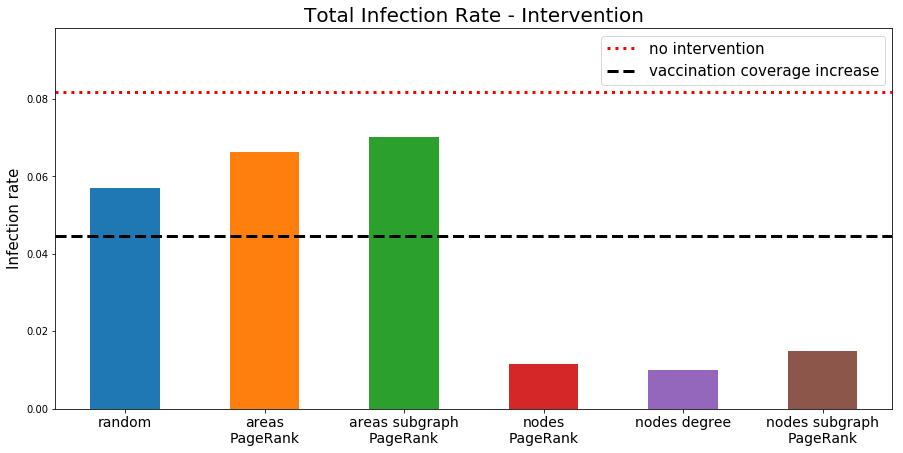

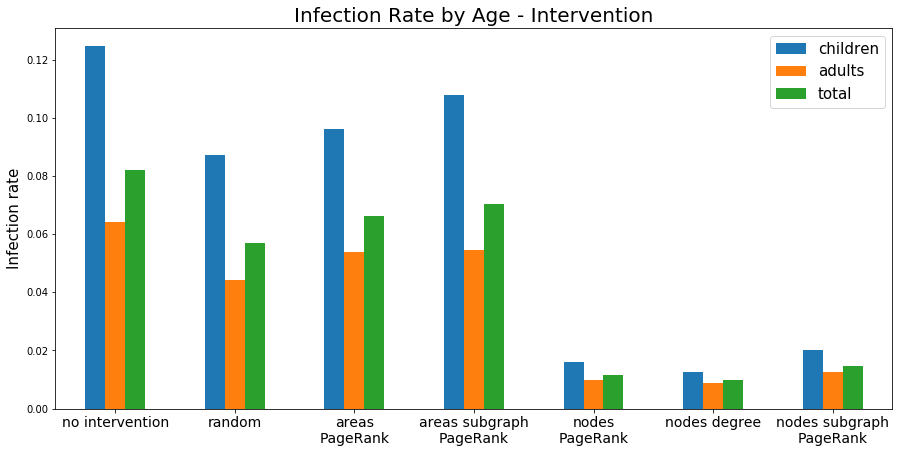

,no intervention,random,areas PageRank,areas subgraph PageRank,nodes PageRank,nodes degree,nodes subgraph PageRank
age,,,,,,,
children,0.124638,0.087202,0.096156,0.107797,0.015877,0.012536,0.020044
adults,0.064132,0.044393,0.053846,0.054593,0.009712,0.008893,0.012571
total,0.081943,0.056994,0.066300,0.070254,0.011527,0.009965,0.014771


In [34]:
# Get only total
intervention_total_infection_rates = intervention_infection_rates.iloc[2,1:]

# Plot
intervention_total_infection_rates.T.plot.bar(figsize=(15, 7))
plt.title('Total Infection Rate - Intervention', size=20)
plt.xlabel('', size=15)
plt.ylabel('Infection rate', size=15)
plt.xticks(np.arange(6), intervention_total_infection_rates.T.index, rotation='horizontal', size=14)
# plt.legend(fontsize=15)

# Total infection rate no intervention
no_inter_line = plt.hlines(intervention_infection_rates.loc['total', 'no intervention'], -0.5, 6,
           linestyle ='dotted', linewidth=3, color='r', label='no intervention')

# Calculate average vaccination coverage increase
V_increase = (np.array(intervention_vacc_coverage[1:]) - intervention_vacc_coverage[0]).mean()

V_increase_line = plt.hlines(intervention_infection_rates.loc['total', 'no intervention'] - V_increase, -0.5, 6,
           linestyle ='--', linewidth=3, color='black')

plt.ylim([0, intervention_infection_rates.loc['total', 'no intervention']*1.2])

plt.legend([no_inter_line, V_increase_line], ['no intervention', 'vaccination coverage increase'], fontsize=15)


plt.show()


# Plot infection rates by age
intervention_infection_rates.T.plot.bar(figsize=(15, 7))
plt.title('Infection Rate by Age - Intervention', size=20)
plt.xlabel('', size=15)
plt.ylabel('Infection rate', size=15)
plt.xticks(np.arange(7), intervention_infection_rates.T.index, rotation='horizontal', size=14)
plt.legend(fontsize=15)
plt.show()

intervention_infection_rates

#### Marginal contribution

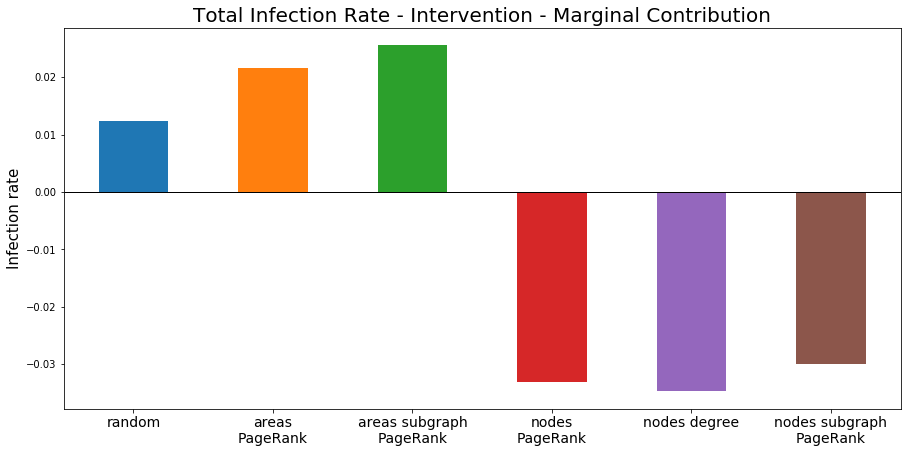

In [35]:
# Get only total
intervention_total_infection_rates_additional = intervention_infection_rates.iloc[2,1:]

# Calculate average vaccination coverage increase
V_increase = (np.array(intervention_vacc_coverage[1:]) - intervention_vacc_coverage[0]).mean()
intervention_total_infection_rates_additional -= intervention_infection_rates.loc['total', 'no intervention'] - V_increase

# Plot
intervention_total_infection_rates_additional.T.plot.bar(figsize=(15, 7))
plt.title('Total Infection Rate - Intervention - Marginal Contribution', size=20)
plt.xlabel('', size=15)
plt.ylabel('Infection rate', size=15)
plt.xticks(np.arange(6), intervention_total_infection_rates_additional.T.index, rotation='horizontal', size=14)

# zero_line
plt.hlines(0, -0.5, 6, linewidth=1)

plt.show()

In [36]:
intervention_total_infection_rates_additional

random                      0.012302
areas\nPageRank             0.021608
areas subgraph\nPageRank    0.025562
nodes\nPageRank            -0.033165
nodes degree               -0.034727
nodes subgraph\nPageRank   -0.029921
Name: total, dtype: float64

#### 2017

In [37]:
# intervention_infection_rates_2017 = intervention_infection_rates.copy()

In [38]:
intervention_total_infection_rates = intervention_infection_rates_2017.iloc[2,1:]

# Plot
intervention_total_infection_rates.T.plot.bar(figsize=(15, 7))
plt.title('Total Infection Rate - Intervention', size=20)
plt.xlabel('', size=15)
plt.ylabel('Infection rate', size=15)
plt.xticks(np.arange(7), xx.T.index, rotation='horizontal', size=14)
# plt.legend(fontsize=15)

# Total infection rate no intervention
no_inter_line = plt.hlines(intervention_infection_rates_2017.loc['total', 'no intervention'], -0.5, 6,
           linestyle ='dotted', linewidth=3, color='r', label='no intervention')

# V increase
V_increase_list = []
for res in results[1:]:
    V_increase_list.append(len(res['V_0'] - res['R'][0]) - len(results_no_inter['V_0'] - results_no_inter['R'][0]))
V_increase = (np.array(aa) / results_no_inter['N']).mean()

V_increase_line = plt.hlines(intervention_infection_rates_2017.loc['total', 'no intervention'] - V_increase, -0.5, 6,
           linestyle ='--', linewidth=3, color='black')

plt.ylim([0, intervention_infection_rates_2017.loc['total', 'no intervention']*1.2])

plt.legend([no_inter_line, V_increase_line], ['no intervention', 'vaccination coverage increase'], fontsize=15)


plt.show()


# Plot
intervention_infection_rates_2017.T.plot.bar(figsize=(15, 7))
plt.title('Infection Rate by Age - Intervention', size=20)
plt.xlabel('', size=15)
plt.ylabel('Infection rate', size=15)
plt.xticks(np.arange(7), intervention_infection_rates_2017.T.index, rotation='horizontal', size=14)
plt.legend(fontsize=15)
plt.show()

intervention_infection_rates

NameError: name 'intervention_infection_rates_2017' is not defined

# OLD